In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.preprocessing import FunctionTransformer
%matplotlib inline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,f_classif
import lightgbm as lgb

In [2]:
RANDOM_SEED = 41
cpus = -1
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

hdth = 'Horizontal_Distance_To_Hydrology'
vdth = 'Vertical_Distance_To_Hydrology'
hdtr = 'Horizontal_Distance_To_Roadways'

In [18]:
def wilderness(X):
    sets = []
    for i in range(1,5):        
        sets.append(X.copy()[X['Wilderness_Area' + str(i)] == 1])
    return sets

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [22]:
Xs = wilderness(train)
Xs_test = wilderness(test)

In [4]:
# extremely stony
extremely_stony = ['Soil_Type' + str(i) for i in [1,24,25,27,28,29,30,31,34,36,37,38,39]]
# rubbly
rubbly = ['Soil_Type' + str(i) for i in [3,4,5,10,11,13]]
# very stony
very_stony = ['Soil_Type' + str(i) for i in [2,9,18,26]]
# stony
stony = ['Soil_Type' + str(i) for i in [6,12]]
lack_info_cols = ['Soil_Type' + str(i) for i in [7,15,14,17,33,32]]
wla = ['Wilderness_Area' + str(i) for i in [1,2,3,4]]
SHADES = ['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']

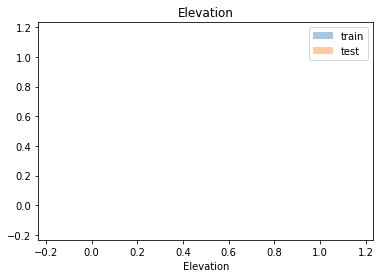

In [45]:
column = 'Elevation' 
wa = 2
filter_column = 'Soil_Type1' 
filter_value = 1
sns.distplot(train[(train[filter_column] == filter_value) & (train['Wilderness_Area' + str(wa)] == 1)][column], label = 'train') 
sns.distplot(test[(test[filter_column] == filter_value) & (test['Wilderness_Area' + str(wa)] == 1)][column], label = 'test') 
plt.legend() 
plt.title(column) 
plt.show()

In [9]:
def features(X, wild):
    hdthz = {}
    vdthz = {}
#     for i in set(list(X[X[hdth] == 0]['Elevation'])):
#         hdthz[i] = int(X[X['Elevation'] == i][hdth].min())
#     for i in set(list(X[X[vdth] == 0]['Elevation'])):
#         vdthz[i] = int(X[X['Elevation'] == i][vdth].min())        
#     for i in X.index:
#         if X.at[i, hdth] == 0:
#             X.loc[i, hdth] = hdthz[X.at[i, 'Elevation']]   
#         if X.at[i, vdth] == 0:
#             X.loc[i, vdth] = vdthz[X.at[i, 'Elevation']]             
    X['HHV'] = np.sqrt(X[vdth]**2 + X[hdth]**2)
    X['HR'] = X[hdth] - X['Horizontal_Distance_To_Roadways']
    X['HF'] = X[hdth] - X['Horizontal_Distance_To_Fire_Points']
    X['RP'] = X['Horizontal_Distance_To_Roadways'] - X['Horizontal_Distance_To_Fire_Points']
    X['Hillshade_3pm'] = np.where(X['Hillshade_3pm'] > 0, X['Hillshade_3pm'], X['Hillshade_Noon'] - X['Hillshade_9am'])
    X['shade_noon_diff'] = X['Hillshade_9am'] - X['Hillshade_Noon']
    X['shade_3pm_diff'] = X['Hillshade_Noon'] - X['Hillshade_3pm']
    X['shade_all_diff'] = X['Hillshade_3pm'] - X['Hillshade_9am']
    X['shade_sum'] = X[SHADES].sum(axis=1)
    X['shade_mean'] = X[SHADES].mean(axis=1)
    X['extremely_stony'] = X[extremely_stony].sum(axis=1)
    X['rubbly'] = X[rubbly].sum(axis=1)
    X['very_stony'] = X[very_stony].sum(axis=1)
    X['stony'] = X[stony].sum(axis=1)
#     X['El'] = np.sin(X['Slope'] * np.pi/180) * X['Elevation']
#     X['slopeH'] = np.sin(X['Slope'] * np.pi/180) * 30
#     X['slopeG'] = X['Slope'] * np.pi/180
#     return X.drop(wla, axis=1)   
#     return X

In [12]:
wild = 0
filteredX = Xs[wild].copy()
X = filteredX.copy().drop(['Cover_Type', 'Id'] + lack_info_cols, axis=1)
X = features(X, wild)
y = filteredX['Cover_Type']
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                              Specs        Score
0                         Elevation  2149.912337
35                      Soil_Type30   412.237685
5   Horizontal_Distance_To_Roadways   390.557899
45                               HR   363.303136
8                     Hillshade_3pm   345.105602
41                      Soil_Type38   315.287876
7                    Hillshade_Noon   245.909607
48                          None3pm   228.687465
2                             Slope   225.544358
42                      Soil_Type39   188.406113


/home/vasste/.local/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [10 11 12 13 14 15 18 19 21 26 30 31 32 33 36 37 39 50] are constant.
  UserWarning)
/home/vasste/.local/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


/home/vasste/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.13191943 0.03089039 0.02178061 0.03041407 0.02838893 0.05028248
 0.0259441  0.02853743 0.02265519 0.04468946 0.         0.01223108
 0.00308907 0.02397917 0.         0.         0.         0.
 0.02496487 0.00772127 0.         0.0162742  0.00204659 0.
 0.00066146 0.00314137 0.00121954 0.00515478 0.00776056 0.00652121
 0.         0.00182248 0.00068586 0.00025375 0.         0.
 0.01093292 0.00102793 0.00866872 0.0005608  0.00035877 0.02839055
 0.03437774 0.02021796 0.03306933 0.03820811 0.04197874 0.04608778
 0.02362846 0.02695363 0.0232852  0.02313244 0.02365928 0.03405357
 0.03918263 0.00919609 0.        ]


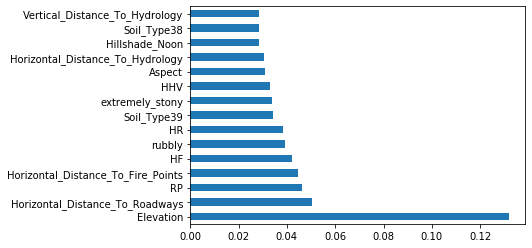

In [44]:
wild = 2
filteredX = Xs[wild].copy()
X = filteredX.copy().drop(['Cover_Type', 'Id'] + lack_info_cols, axis=1)
X = features(X, wild)
y = filteredX['Cover_Type']
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

In [29]:
rf = RandomForestClassifier(n_estimators = 250, random_state = RANDOM_SEED, n_jobs = cpus)
gb = GradientBoostingClassifier(n_estimators = 150, random_state = RANDOM_SEED)                                        
lgb = gbm = lgb.LGBMRegressor()
for wild in range(0, 4):    
    filteredX = Xs[wild].copy()
#     filteredX = filteredX[filteredX[hdth] > 0]
    X = filteredX.copy().drop(['Cover_Type', 'Id'] + lack_info_cols, axis=1)
    y = filteredX['Cover_Type']
    features(X, wild)    
    for cl in [gb]:          
        print(wild, cross_val_score(cl, X, y, cv = 5, scoring='accuracy', n_jobs = cpus).mean())

AttributeError: 'LGBMRegressor' object has no attribute 'LGBMRegressor'

In [10]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
features(train, 0)
features(test, 0)

In [11]:
wild = 0
filteredX = Xs[wild].copy()
X = filteredX.copy().drop(['Id'] + lack_info_cols, axis=1)
X = features(X, wild)
corrmat = X.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(X[top_corr_features].corr(),annot=True,cmap="RdYlGn")

NameError: name 'Xs' is not defined

In [ ]:
def classifier(X):
    global RANDOM_SEED
    return RandomForestClassifier(n_estimators = 250, random_state = RANDOM_SEED)

wld_pred = []
for i in range(1,5):      
    train_wld = train.copy()[train['Wilderness_Area' + str(i)] == 1]
    test_wld = test.copy()[test['Wilderness_Area' + str(i)] == 1]
    
    X = train_wld.copy().drop(['Cover_Type', 'Id'] + lack_info_cols, axis=1)
    y = train_wld.copy()['Cover_Type']
    X_test = test_wld.copy().drop(['Id'] + lack_info_cols, axis=1)
    
    clf = classifier(X)
    clf.fit(X, y)
    pred = clf.predict(X_test)
    sub_pd = pd.DataFrame(pred, columns=['Cover_Type'], index=X_test.index)
    sub_pd['Id'] = test_wld['Id']  
    wld_pred.append(sub_pd)
    
submission = pd.concat(wld_pred)
submission.to_csv('submission.csv', index=False)

In [ ]:
train.columns